# 📝 Text super-resolution
* team name and members: Super-girls, **Agata Żywot 148258, Zuzanna Gawrysiak 148255**
* selected problem and dataset: Super-resolution, [TextZoom](https://paperswithcode.com/dataset/textzoom)

In [2]:
import cv2
import PIL
import numpy as np
from IPython.display import display
import os
import sys
if '../' not in sys.path:
    sys.path.append('../')
import tqdm
import random
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
print("Using torch", torch.__version__)

from src.mdb_to_jpg import mdb_to_jpg
from src.utils import *
from src.data import *
from src.models.srresnet import _NetG, _NetD
from src.models.srgan_train import sr_gan_perform_training
from src.models.srresnet_train import sr_resnet_perform_training
from src.models.gestalt.tsrn import TSRN
from src.cfg import *

Using torch 1.13.0+cpu


In [3]:
torch.manual_seed(8)
random.seed(8)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda") 
    
else:
    device = torch.device("cpu")

print(f"Using torch { torch.__version__} on {device}")

Using torch 1.13.0+cpu on cpu


In [4]:
torch.cuda.empty_cache()

## Dataset

### Description
Number of images in each subset:
* train: 17367
* test:
    * easy: 1619
    * medium: 1411
    * hard: 1343

In [5]:
# TODO change for train1 at the end since it's > 10000
data_path = 'data/TextZoom/train2_img/'
lmdb_file = 'data/TextZoom/train2'
N = mdb_to_jpg(data_path, lmdb_file)

Number of samples: 2794


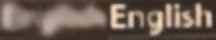

In [6]:
# DISPLAY EXEMPLARY IMAGES
x = 10
imgHR = cv2.imread(data_path+str(x)+'_img_HR.jpg', 1)
imgLR = cv2.imread(data_path+str(x)+'_img_LR.jpg', 1)
show_LR_HR_images(imgLR, imgHR)

In [7]:
# GET HR AND LR images
img_data = get_data_from_dir(data_path, [str(i) for i in range(1, N+1)])

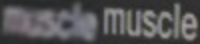

In [8]:
# GET HR AND LR images
data = get_data_from_dir(data_path, [str(i) for i in range(1, N+1)])
x = 1234
show_LR_HR_images(img_data[x][0], img_data[x][1])

### Data preprocessing

In [9]:
LR_images = list(map(lambda x: x[0].shape[:-1], img_data))
HR_images = list(map(lambda x: x[1].shape[:-1], img_data))

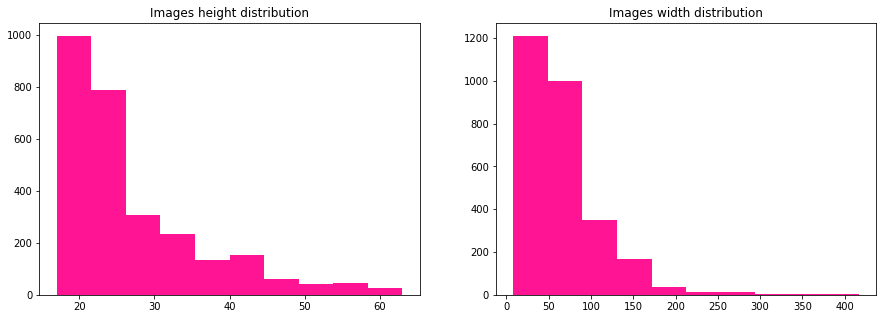

In [10]:
get_height_width_distribution(LR_images)

**NOTE: We preprocessed the data according to the paper [arXiv:2005.03341](https://arxiv.org/abs/2005.03341):** <br>
*"We up-sample the images ranging from 16-
32 pixels height to 32 pixels height, and up-sample the images ranging from 8-16
pixels height to 16 pixels height. We conclude that (16, 32) should be a good
pair to form a 2X train set for scene text SR task. For example, the text images
taken from 150mm focal length and height sized in 16-32 pixels would be taken
as a ground truth for the 70mm counterpart. So we selected all the images the
height of which range from 16 pixels to 32 pixels as our ground truth image and
up-sample them to the size of 128×32 (width×height), and the corresponding 2X
LR images to the size of 64×16 (width×height)."*

In [11]:
# TODO -> replace src.data.SRDataset with the final one
class SRDataset(Dataset):
    def __init__(self, images, crop=True, normalize=True): 
        self.normalize = normalize
        self.crop = crop
        self.images = images

    def __len__(self):
        return len(self.images)

    def preprocess_image(self, image):
        lr = image[0]
        hr = image[1]
        if self.crop:
            lr = cv2.resize(lr, (64, 16))
            hr = cv2.resize(hr, (128, 32))
        if self.normalize:

            # TODO: uncomment the line below and comment the subsequent two b4 training 
            # lr = lr / 255 # [0; 1]
            lr = lr.astype(np.float32)
            lr = (lr - 127.5) / 127.5 # [-1; 1]

            hr = hr.astype(np.float32)
            hr = (hr - 127.5) / 127.5 # [-1; 1]

        return torch.tensor(lr).swapaxes(1,2).swapaxes(0,1), torch.tensor(hr).swapaxes(1,2).swapaxes(0,1)

    def __getitem__(self, index):        
        image = self.images[index]         
        return self.preprocess_image(image)

In [17]:
img_data_processed = SRDataset(img_data)

torch.Size([3, 16, 64])

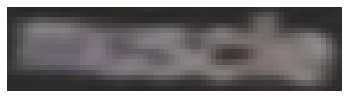

In [18]:
x = 1234
display_img_tensor(img_data_processed[x][0], rescale=True)
img_data_processed[x][0].shape

torch.Size([3, 32, 128])

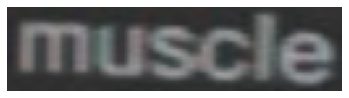

In [19]:
display_img_tensor(img_data_processed[x][1], rescale=True)
img_data_processed[x][1].shape

In [20]:
train_indices, test_indices = train_test_split(range(N), test_size=0.2)
len(train_indices), len(test_indices)

(2235, 559)

In [21]:
train_set = torch.utils.data.Subset(img_data_processed, train_indices)
test_set = torch.utils.data.Subset(img_data_processed, test_indices)

## Models

### SRResNet

In [23]:
cfg = read_config("cfg/models/srresnet.yaml")
cfg['epochs'] = 50

sr_resnet_perform_training(train_set=train_set, cfg=cfg, save='6')

https://app.neptune.ai/super-girls/Super-Resolution/e/SR-73
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
===> Runs with VGG model support (VGG loss applied)
===> Setting Optimizers
===> Training


Epoch 50: 100%|██████████| 140/140 [00:25<00:00,  5.54batch/s, MSE_loss=0.0296, VGG_loss=0.0506]

Shutting down background jobs, please wait a moment...


Done!
Waiting for the remaining 38 operations to synchronize with Neptune. Do not kill this process.
All 38 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/super-girls/Super-Resolution/e/SR-73
Model saved to checkpoint/model_6.pth
https://app.neptune.ai/super-girls/Super-Resolution/m/SR-SRRN6/v/SR-SRRN6-10
Remember to stop your model_version once you’ve finished logging your metadata (https://docs.neptune.ai/api/model_version#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/super-girls/Super-Resolution/m/SR-SRRN6/v/SR-SRRN6-10/metadata


#### Exemplary predictions

In [68]:
checkpoint = torch.load('checkpoint/sr_resnet.pth', map_location=torch.device(device))
sr_resnet = checkpoint['model']
sr_resnet = sr_resnet.eval()

In [69]:
x = 18
LR_image = test_set[x][0]
HR_image = test_set[x][1]

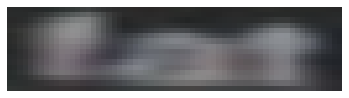

In [70]:
display_img_tensor(LR_image, rescale=True)

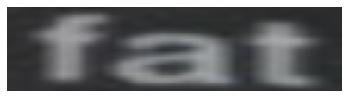

In [71]:
display_img_tensor(HR_image, rescale=True)

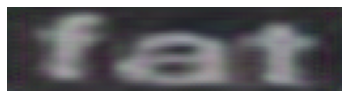

In [72]:
show_prediction(LR_image, sr_resnet)

### SRGAN

In [ ]:
# TODO - GAN (Agata)
cfg = read_config("cfg/models/srresnet.yaml")
cfg['epochs'] = 5

# sr_gan_perform_training(train_set=train_set, cfg=cfg, run_neptune=False)
sr_gan_perform_training(train_set=test_set, cfg=cfg, vgg_loss=False, save='blabla')

### Text Gestalt

The next tested model is based on the paper ["Text Gestalt: Stroke-Aware Scene Text Image Super-Resolution"](https://arxiv.org/pdf/2112.08171v1.pdf). We used code available at [GitHub](https://github.com/FudanVI/FudanOCR/tree/main/text-gestalt) and trained the net architecture from scratch.

The model is inspired by Gestalt Psychology, which states that humans can construct the complete appearance of object with the guidance of local details. Therefore English characters can be decomposed as follows:

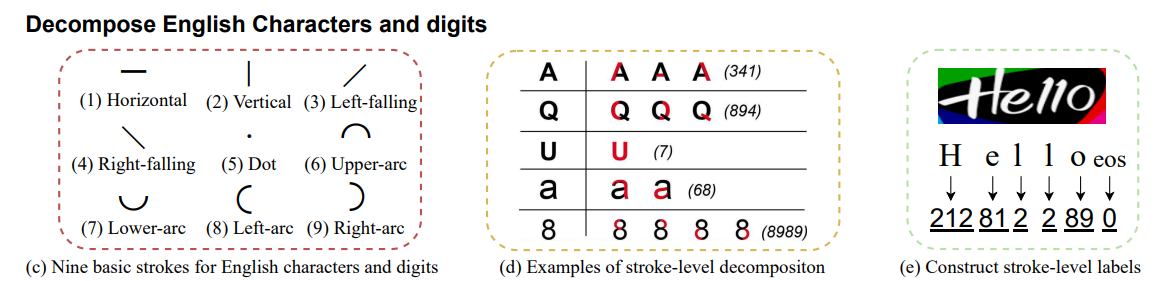
#### Overall architecture
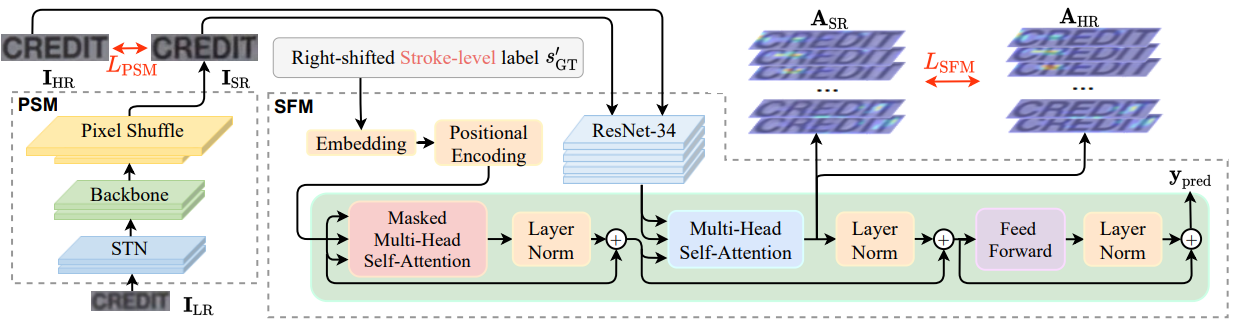

It is worth noticining that the model uses [Multi-Head Self-Attention](https://arxiv.org/pdf/1706.03762v5.pdf) to generate stroke-level maps.
#### Model analysis
* size: 10.3MB
* number of parameters: 2671020
* used metrics: 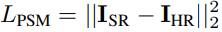
#### Learning curves

#### Sample images

In [52]:
from src.models.gestalt.tsrn import TSRN

In [58]:
device

device(type='cpu')

In [60]:
def transform_(path):
    img = Image.open(path)
    img = img.resize((64, 16), Image.BICUBIC)
    img_tensor = transforms.ToTensor()(img)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

checkpoint = torch.load('checkpoint/gestalt.pth', map_location=torch.device(device))
# print(checkpoint)
gestalt = TSRN()
# print(gestalt)
gestalt.to(device)
gestalt.load_state_dict(checkpoint['state_dict_G'])
gestalt.eval()

{'state_dict_G': OrderedDict([('block1.0.weight', tensor([[[[ 4.0178e-02, -1.7995e-03, -5.4213e-02,  ..., -1.3740e-02,
            3.8002e-02, -5.0282e-02],
          [-4.2577e-02,  4.8213e-02, -6.6861e-02,  ..., -6.2774e-02,
            5.8405e-03,  4.0984e-02],
          [ 6.7730e-02,  1.8010e-02, -1.6085e-02,  ...,  3.8832e-02,
            2.0921e-02, -1.6823e-02],
          ...,
          [ 5.1668e-02,  4.6859e-02,  4.8730e-02,  ...,  5.7992e-02,
            2.2464e-02, -6.8720e-02],
          [ 1.4923e-02,  2.0870e-02,  5.8407e-02,  ...,  2.8654e-02,
           -4.6795e-02, -3.1577e-02],
          [ 9.7617e-03,  7.3087e-03, -2.5867e-02,  ..., -2.0135e-02,
           -3.4719e-02,  4.9011e-02]],

         [[ 7.4085e-03, -3.0150e-02,  1.7473e-02,  ...,  4.0771e-02,
            2.4080e-04,  3.5578e-03],
          [-7.9973e-03,  4.9820e-02, -5.0288e-02,  ...,  2.1522e-02,
            2.4682e-02,  6.2997e-04],
          [ 1.7394e-02,  5.9119e-03,  1.5305e-02,  ...,  2.3227e-02,
        

RuntimeError: Error(s) in loading state_dict for TSRN:
	Unexpected key(s) in state_dict: "tps.inverse_kernel", "tps.padding_matrix", "tps.target_coordinate_repr", "tps.target_control_points", "stn_head.stn_convnet.0.0.weight", "stn_head.stn_convnet.0.0.bias", "stn_head.stn_convnet.0.1.weight", "stn_head.stn_convnet.0.1.bias", "stn_head.stn_convnet.0.1.running_mean", "stn_head.stn_convnet.0.1.running_var", "stn_head.stn_convnet.0.1.num_batches_tracked", "stn_head.stn_convnet.2.0.weight", "stn_head.stn_convnet.2.0.bias", "stn_head.stn_convnet.2.1.weight", "stn_head.stn_convnet.2.1.bias", "stn_head.stn_convnet.2.1.running_mean", "stn_head.stn_convnet.2.1.running_var", "stn_head.stn_convnet.2.1.num_batches_tracked", "stn_head.stn_convnet.4.0.weight", "stn_head.stn_convnet.4.0.bias", "stn_head.stn_convnet.4.1.weight", "stn_head.stn_convnet.4.1.bias", "stn_head.stn_convnet.4.1.running_mean", "stn_head.stn_convnet.4.1.running_var", "stn_head.stn_convnet.4.1.num_batches_tracked", "stn_head.stn_convnet.6.0.weight", "stn_head.stn_convnet.6.0.bias", "stn_head.stn_convnet.6.1.weight", "stn_head.stn_convnet.6.1.bias", "stn_head.stn_convnet.6.1.running_mean", "stn_head.stn_convnet.6.1.running_var", "stn_head.stn_convnet.6.1.num_batches_tracked", "stn_head.stn_convnet.8.0.weight", "stn_head.stn_convnet.8.0.bias", "stn_head.stn_convnet.8.1.weight", "stn_head.stn_convnet.8.1.bias", "stn_head.stn_convnet.8.1.running_mean", "stn_head.stn_convnet.8.1.running_var", "stn_head.stn_convnet.8.1.num_batches_tracked", "stn_head.stn_convnet.10.0.weight", "stn_head.stn_convnet.10.0.bias", "stn_head.stn_convnet.10.1.weight", "stn_head.stn_convnet.10.1.bias", "stn_head.stn_convnet.10.1.running_mean", "stn_head.stn_convnet.10.1.running_var", "stn_head.stn_convnet.10.1.num_batches_tracked", "stn_head.stn_fc1.0.weight", "stn_head.stn_fc1.0.bias", "stn_head.stn_fc1.1.weight", "stn_head.stn_fc1.1.bias", "stn_head.stn_fc1.1.running_mean", "stn_head.stn_fc1.1.running_var", "stn_head.stn_fc1.1.num_batches_tracked", "stn_head.stn_fc2.weight", "stn_head.stn_fc2.bias". 

In [65]:
print(checkpoint.keys())
checkpoint['info']

dict_keys(['state_dict_G', 'info', 'best_history_res', 'best_model_info', 'param_num', 'converge'])


{'arch': 'tsrn',
 'iters': 44000,
 'epochs': 40,
 'batch_size': 16,
 'voc_type': 'all',
 'up_scale_factor': 2}

In [ ]:
demo_dir = 'data/test/easy'

for im_name in tqdm(os.listdir(demo_dir)):
    images_lr = transform_(os.path.join(demo_dir, im_name))
    images_lr = images_lr.to(device)
    images_sr = gestalt(images_lr)